In [2]:
import pandas as pd
import requests
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Configuration
DATASET_URL = "https://data.cityofnewyork.us/resource/i4gi-tjb9.json"
CHUNK_SIZE = 50000 
MAX_WORKERS = 4  # Standard Rule: Use 4-8 threads for downloads. Too many will get you banned by the API.

def fetch_chunk(offset, start_date, end_date):
    where_clause = f"data_as_of BETWEEN '{start_date}' AND '{end_date}'"
    select_clause = "data_as_of, speed, link_id, borough, encoded_poly_line"
    
    params = {
        "$where": where_clause,
        "$select": select_clause,
        "$limit": CHUNK_SIZE,
        "$order": "data_as_of ASC",
        "$offset": offset
    }
    
    r = requests.get(DATASET_URL, params=params)
    if r.status_code == 200:
        return r.json()
    else:
        print(f"Error fetching offset {offset}: {r.status_code}")
        return []

def parallel_fetch(start_date, end_date, filename):
    if os.path.exists(filename):
        os.remove(filename)
        print(f"Deleted old {filename} to start fresh.")

    print(f"🔎 Checking total row count for {filename}...")
    count_query = {
        "$where": f"data_as_of BETWEEN '{start_date}' AND '{end_date}'",
        "$select": "count(*)"
    }
    r = requests.get(DATASET_URL, params=count_query)
    total_rows = int(r.json()[0]['count'])
    print(f"Total rows to fetch: {total_rows}")

    offsets = list(range(0, total_rows, CHUNK_SIZE))
    
    all_rows = []
    
    print(f"Starting Download with {MAX_WORKERS} workers...")
    
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Submit all tasks to the pool
        future_to_offset = {executor.submit(fetch_chunk, offset, start_date, end_date): offset for offset in offsets}
        
        for future in as_completed(future_to_offset):
            data = future.result()
            if data:
                all_rows.extend(data)
                print(f"  ({len(all_rows)} of {total_rows} rows ready)")

    print("Saving to CSV...")
    df = pd.DataFrame(all_rows)
    df.to_csv(filename, index=False)
    print("Done!")

In [5]:
parallel_fetch("2026-01-09T00:00:00", "2026-01-16T00:00:00", "../data/nyc_traffic_baseline.csv")
parallel_fetch("2026-01-23T00:00:00", "2026-01-30T00:00:00", "../data/nyc_traffic_storm.csv")

🔎 Checking total row count for ../data/nyc_traffic_baseline.csv...
Total rows to fetch: 248744
Starting Download with 4 workers...
  (50000 of 248744 rows ready)
  (100000 of 248744 rows ready)
  (150000 of 248744 rows ready)
  (198744 of 248744 rows ready)
  (248744 of 248744 rows ready)
Saving to CSV...
Done!
🔎 Checking total row count for ../data/nyc_traffic_storm.csv...
Total rows to fetch: 248000
Starting Download with 4 workers...
  (50000 of 248000 rows ready)
  (100000 of 248000 rows ready)
  (148000 of 248000 rows ready)
  (198000 of 248000 rows ready)
  (248000 of 248000 rows ready)
Saving to CSV...
Done!


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

/var/folders/jq/y2kzd93d76jbj3szdx797mkh0000gn/T/ipykernel_30178/2533588507.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = df['data_as_of'].dt.floor('h')
/var/folders/jq/y2kzd93d76jbj3szdx797mkh0000gn/T/ipykernel_30178/2533588507.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = df['data_as_of'].dt.floor('h')


Generating Chart 1: The Citywide...


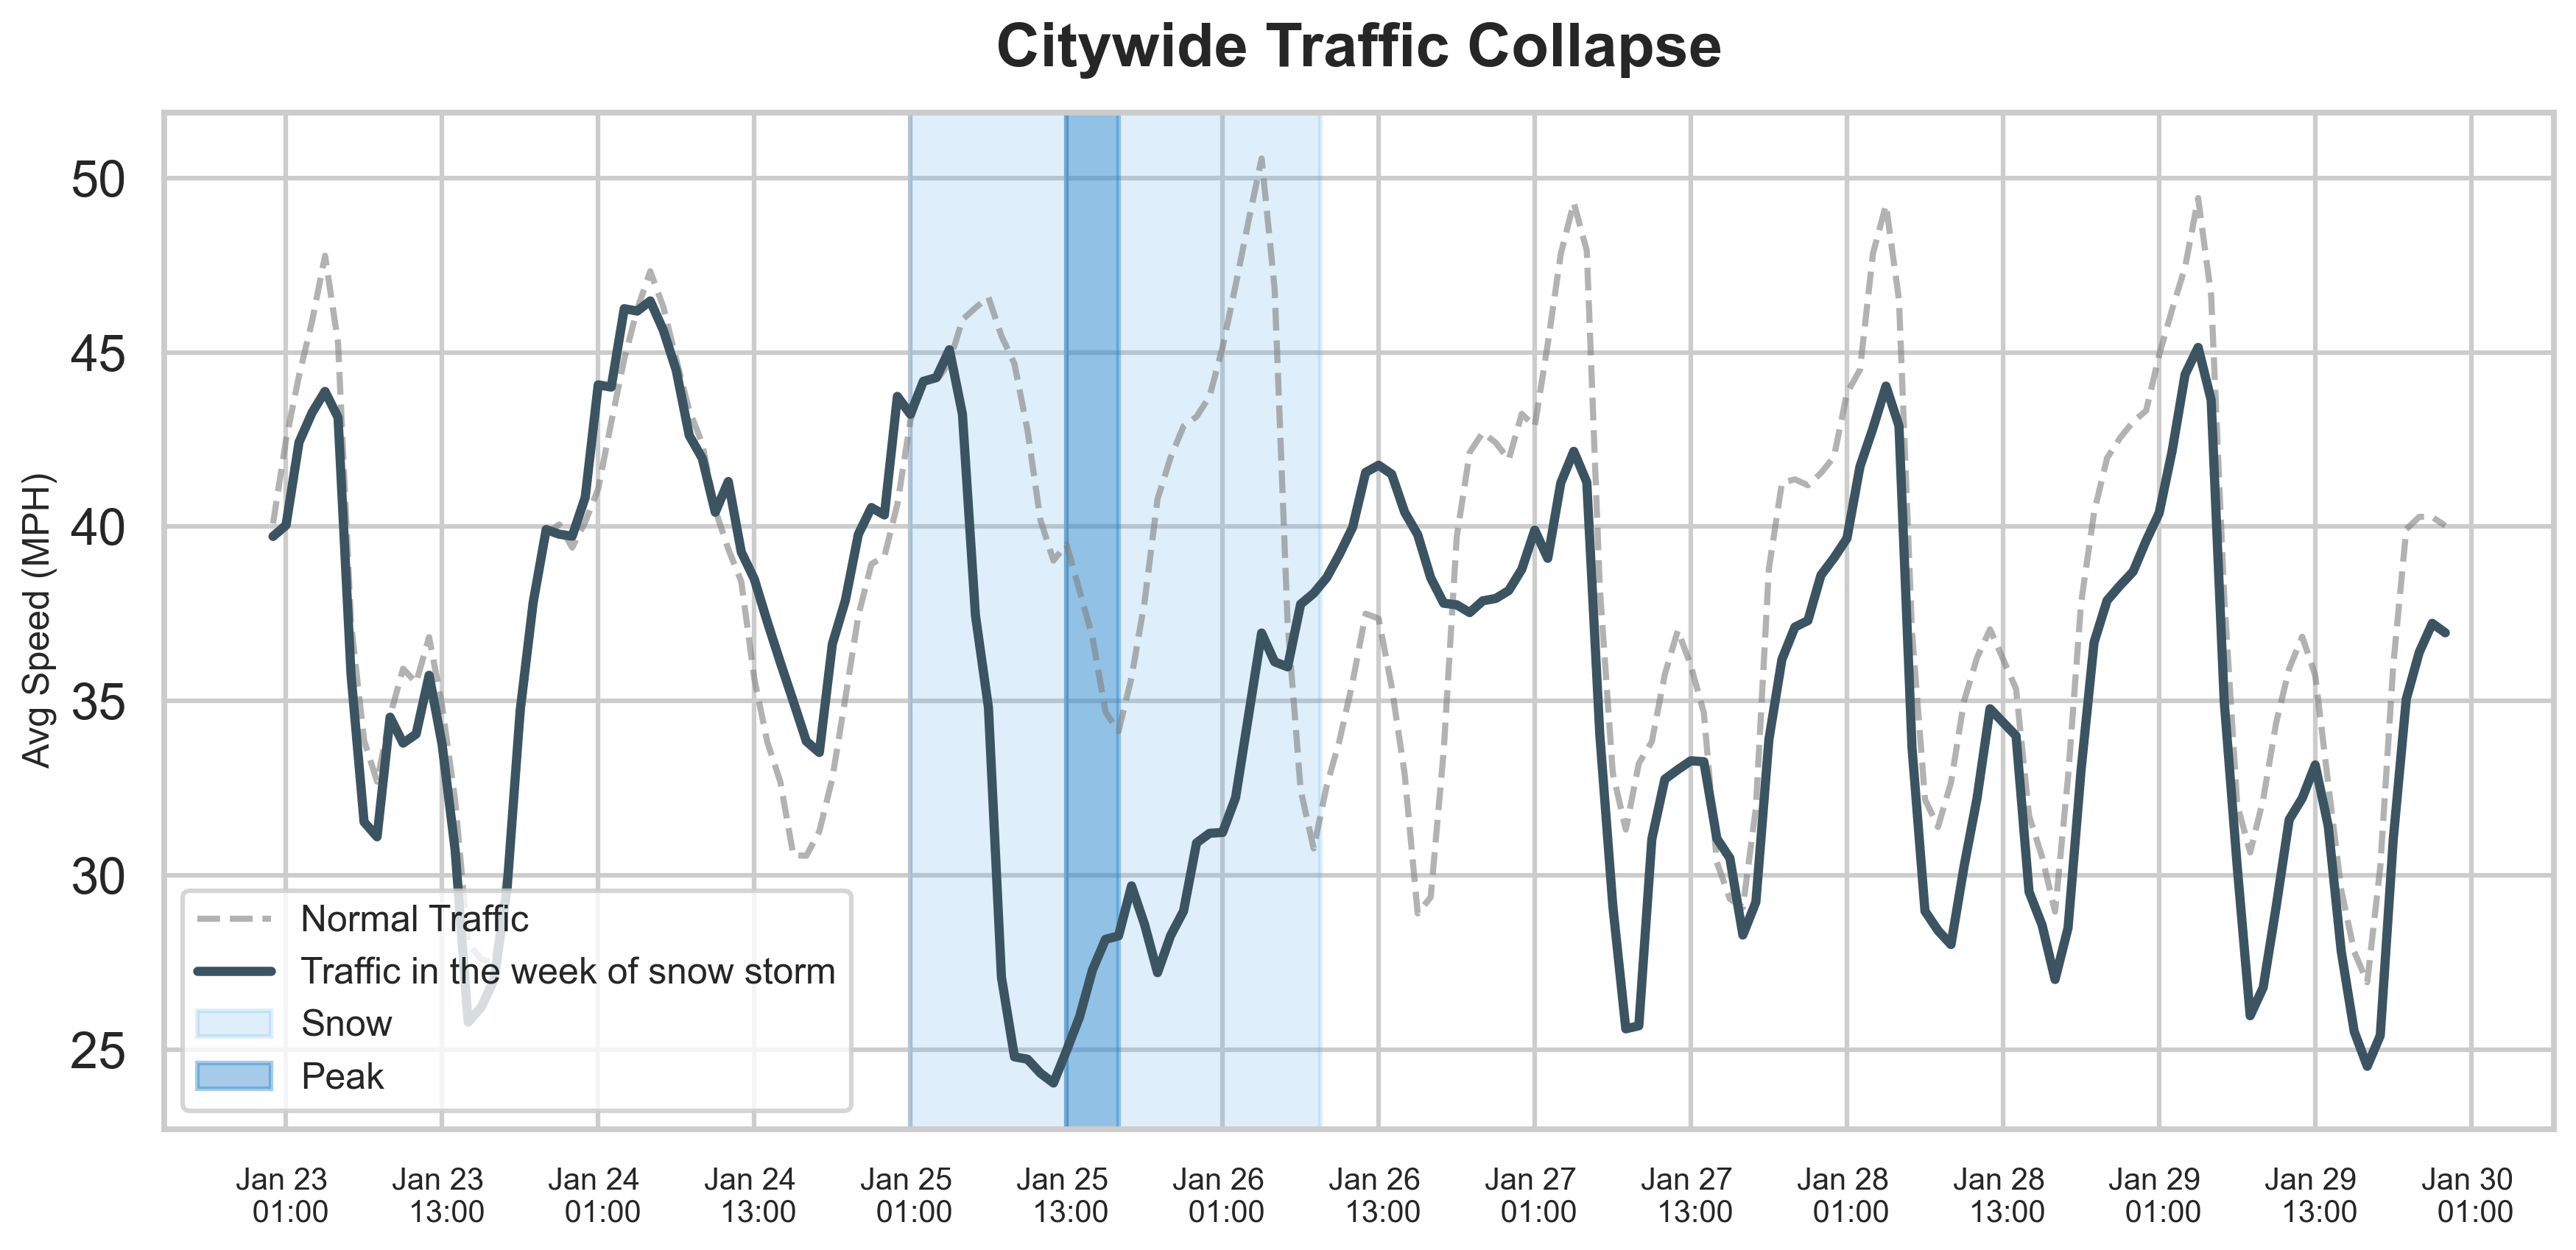

Generating Chart 2: The Borough Divide...


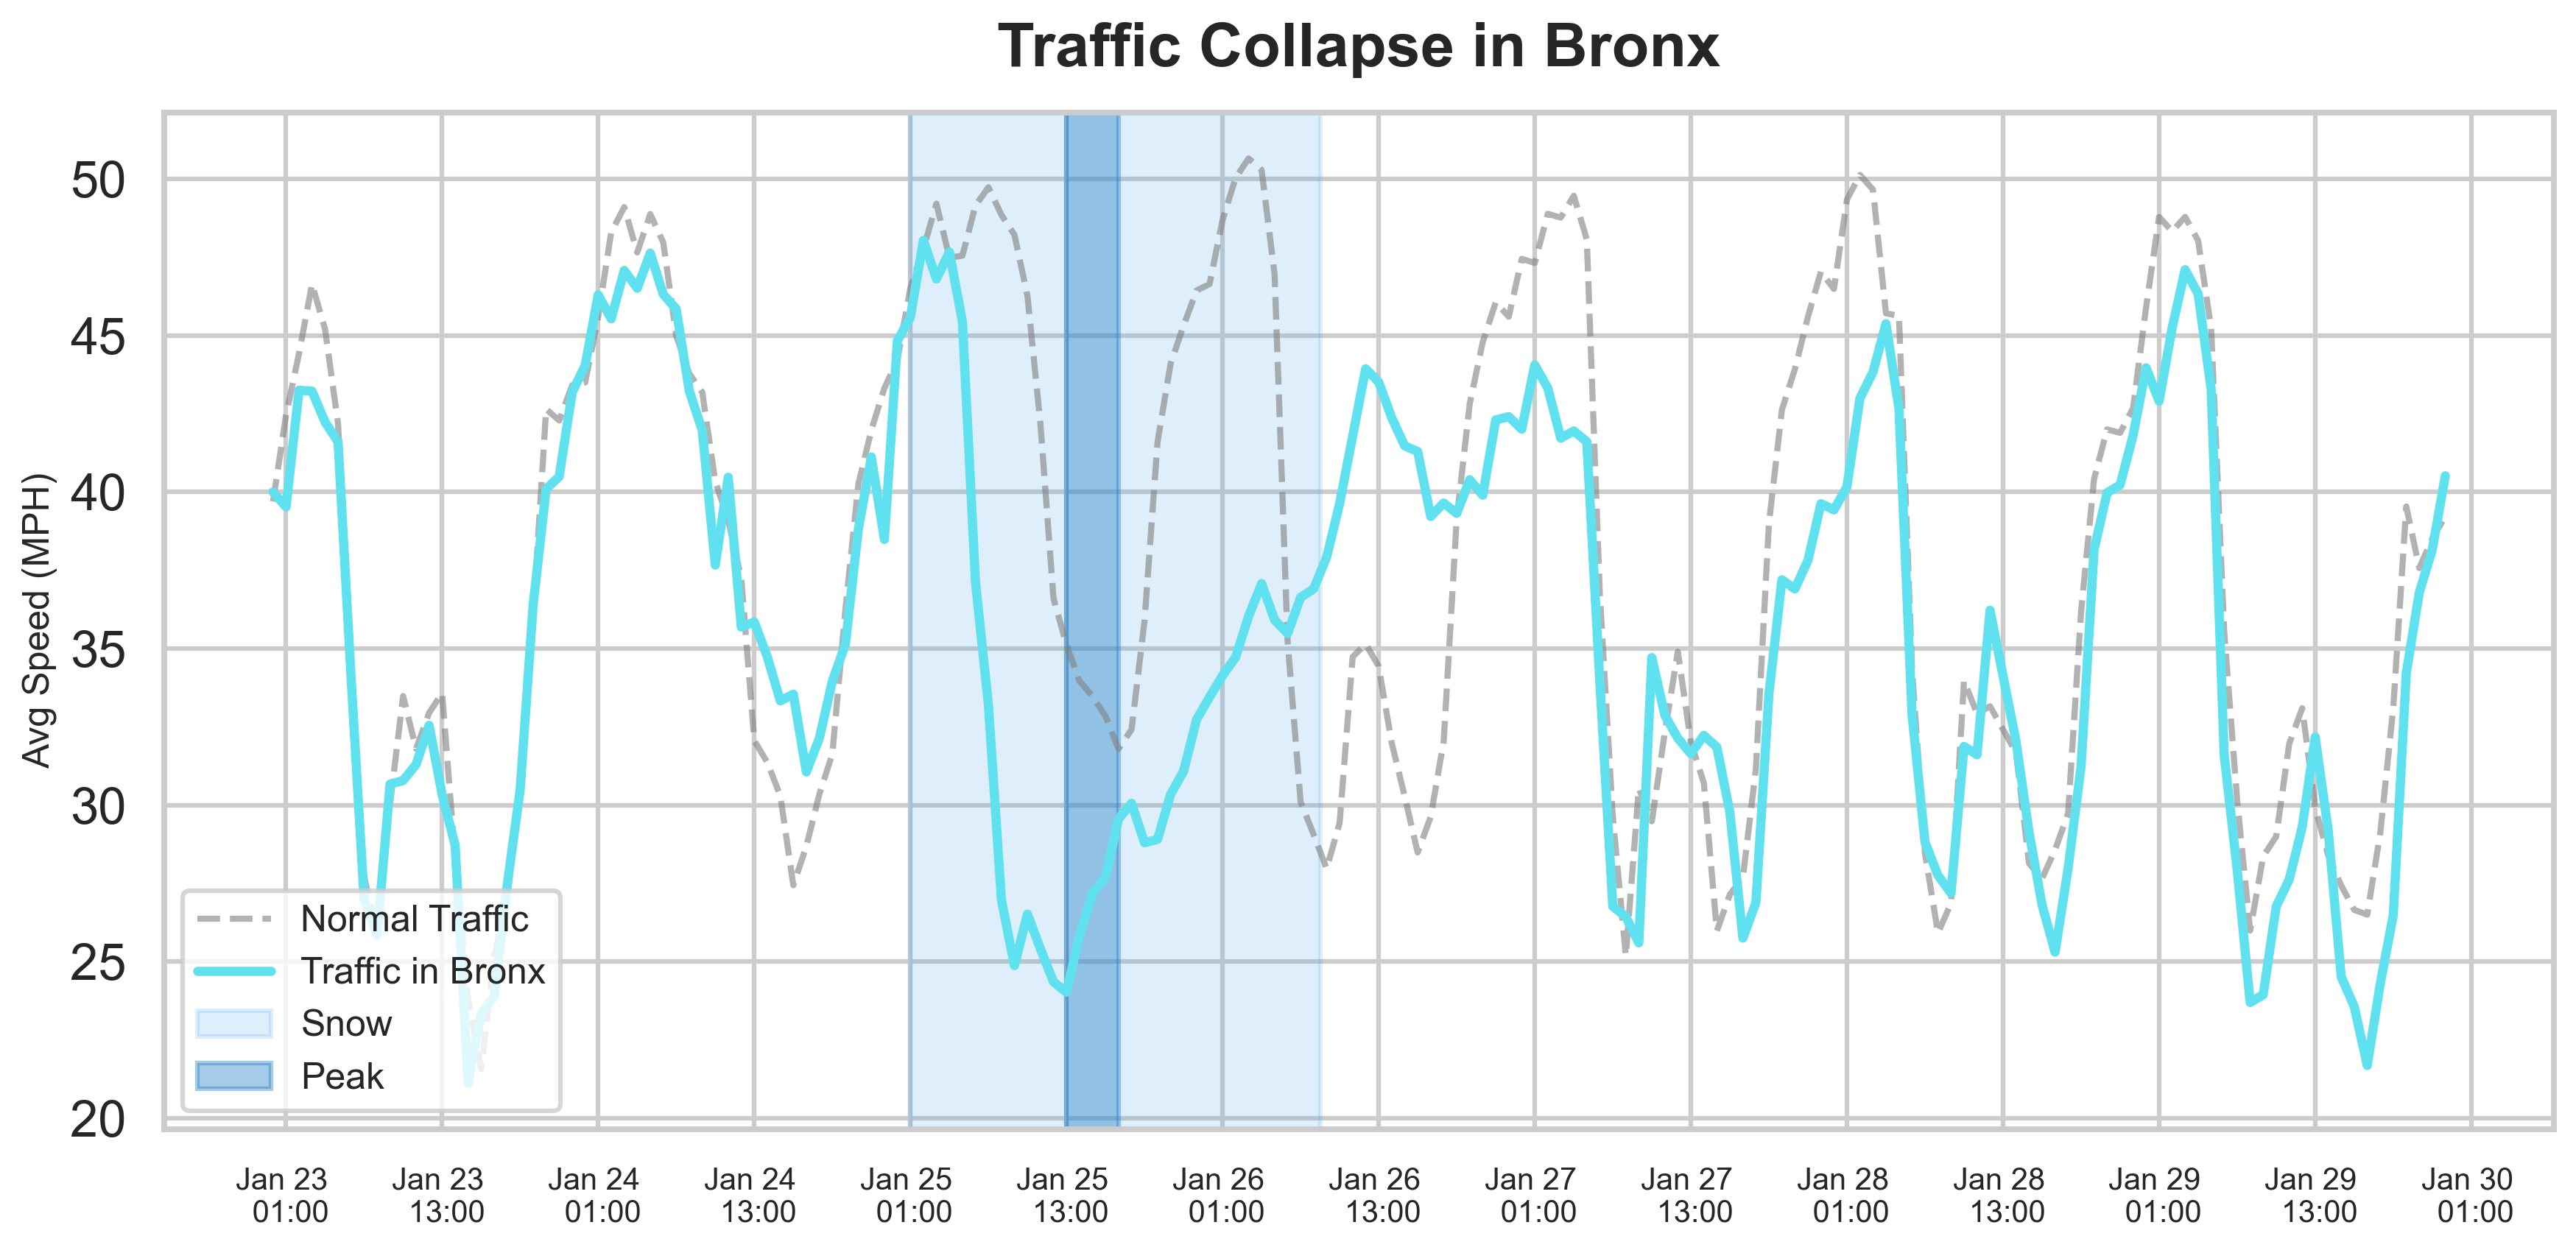

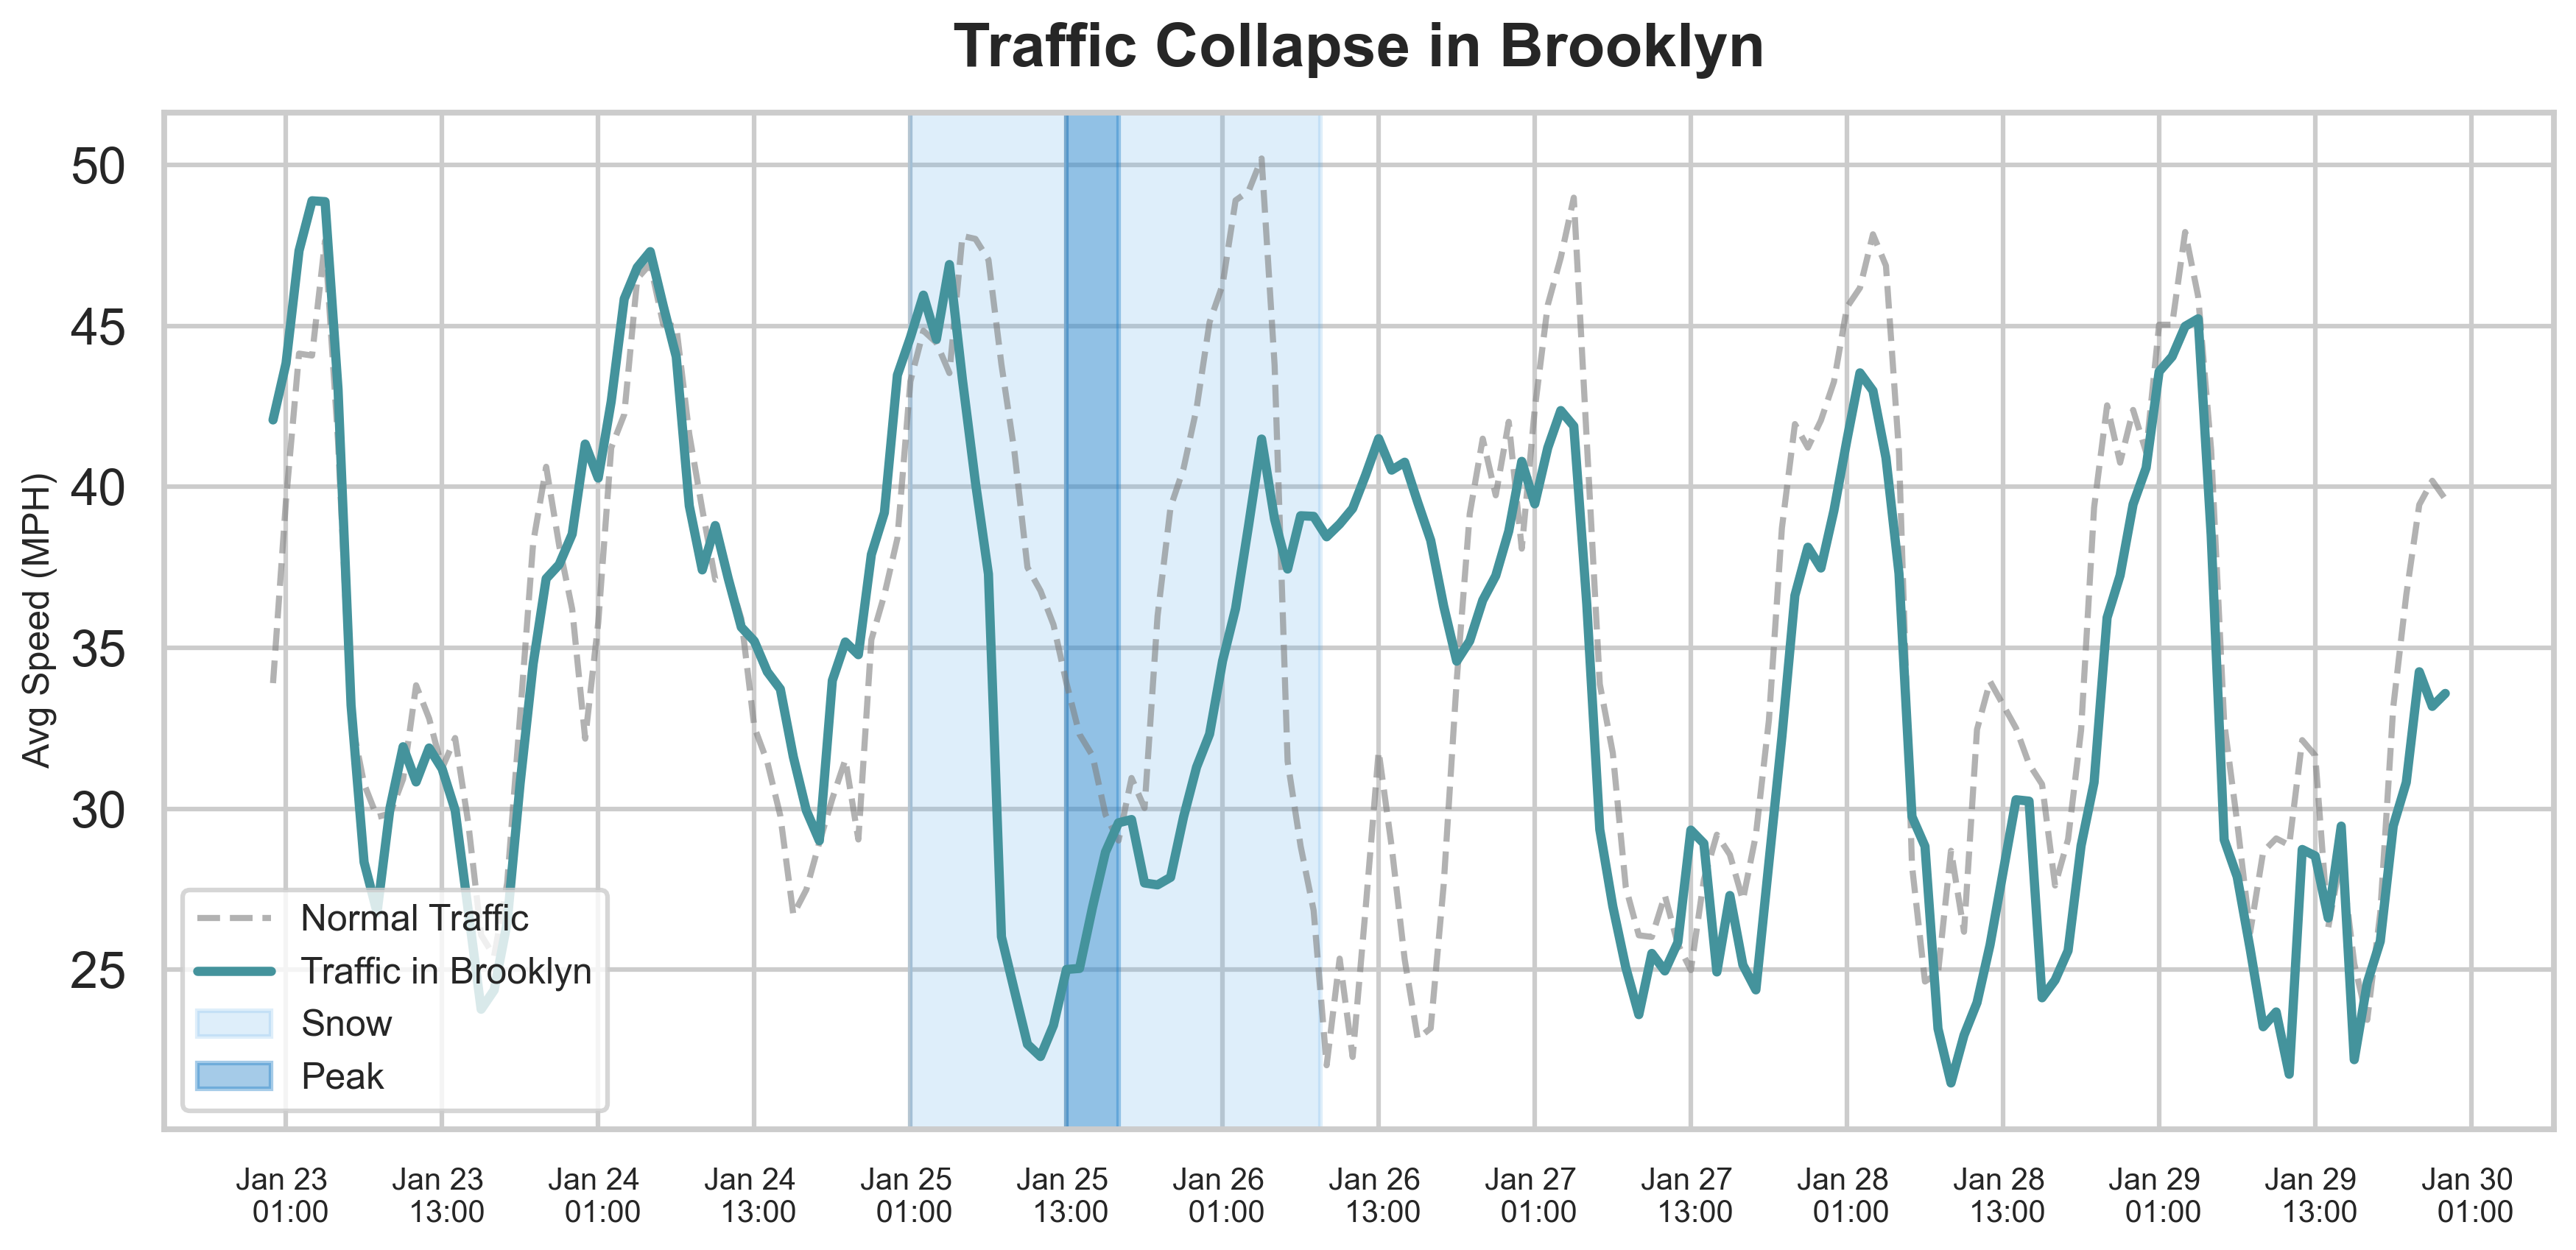

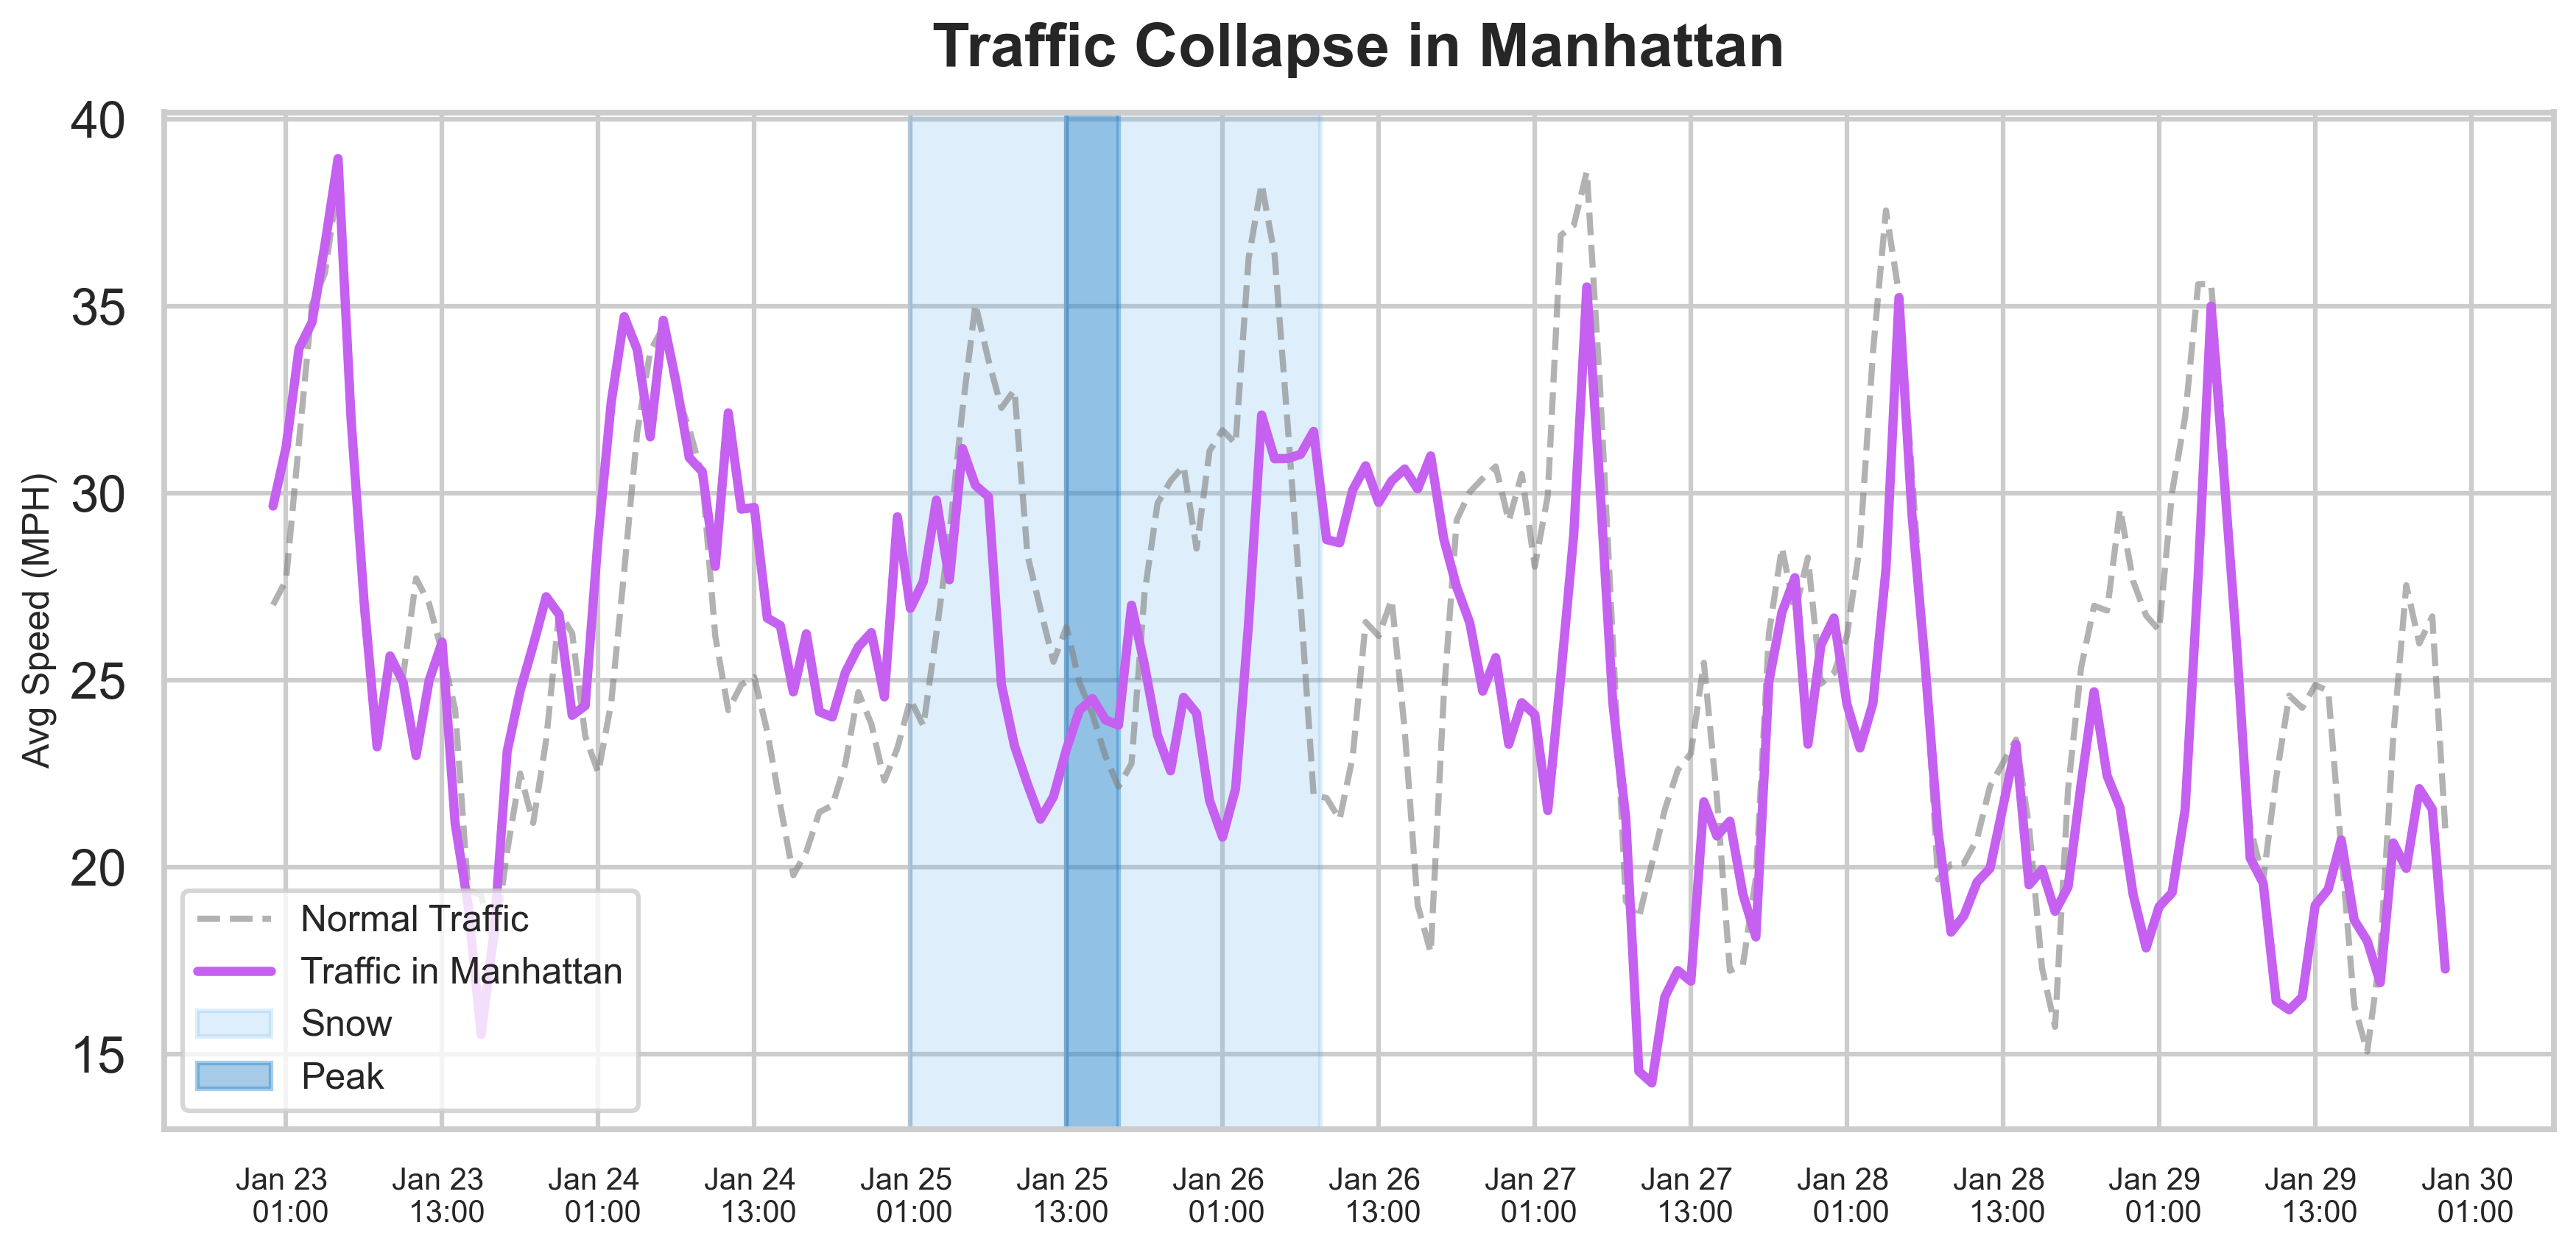

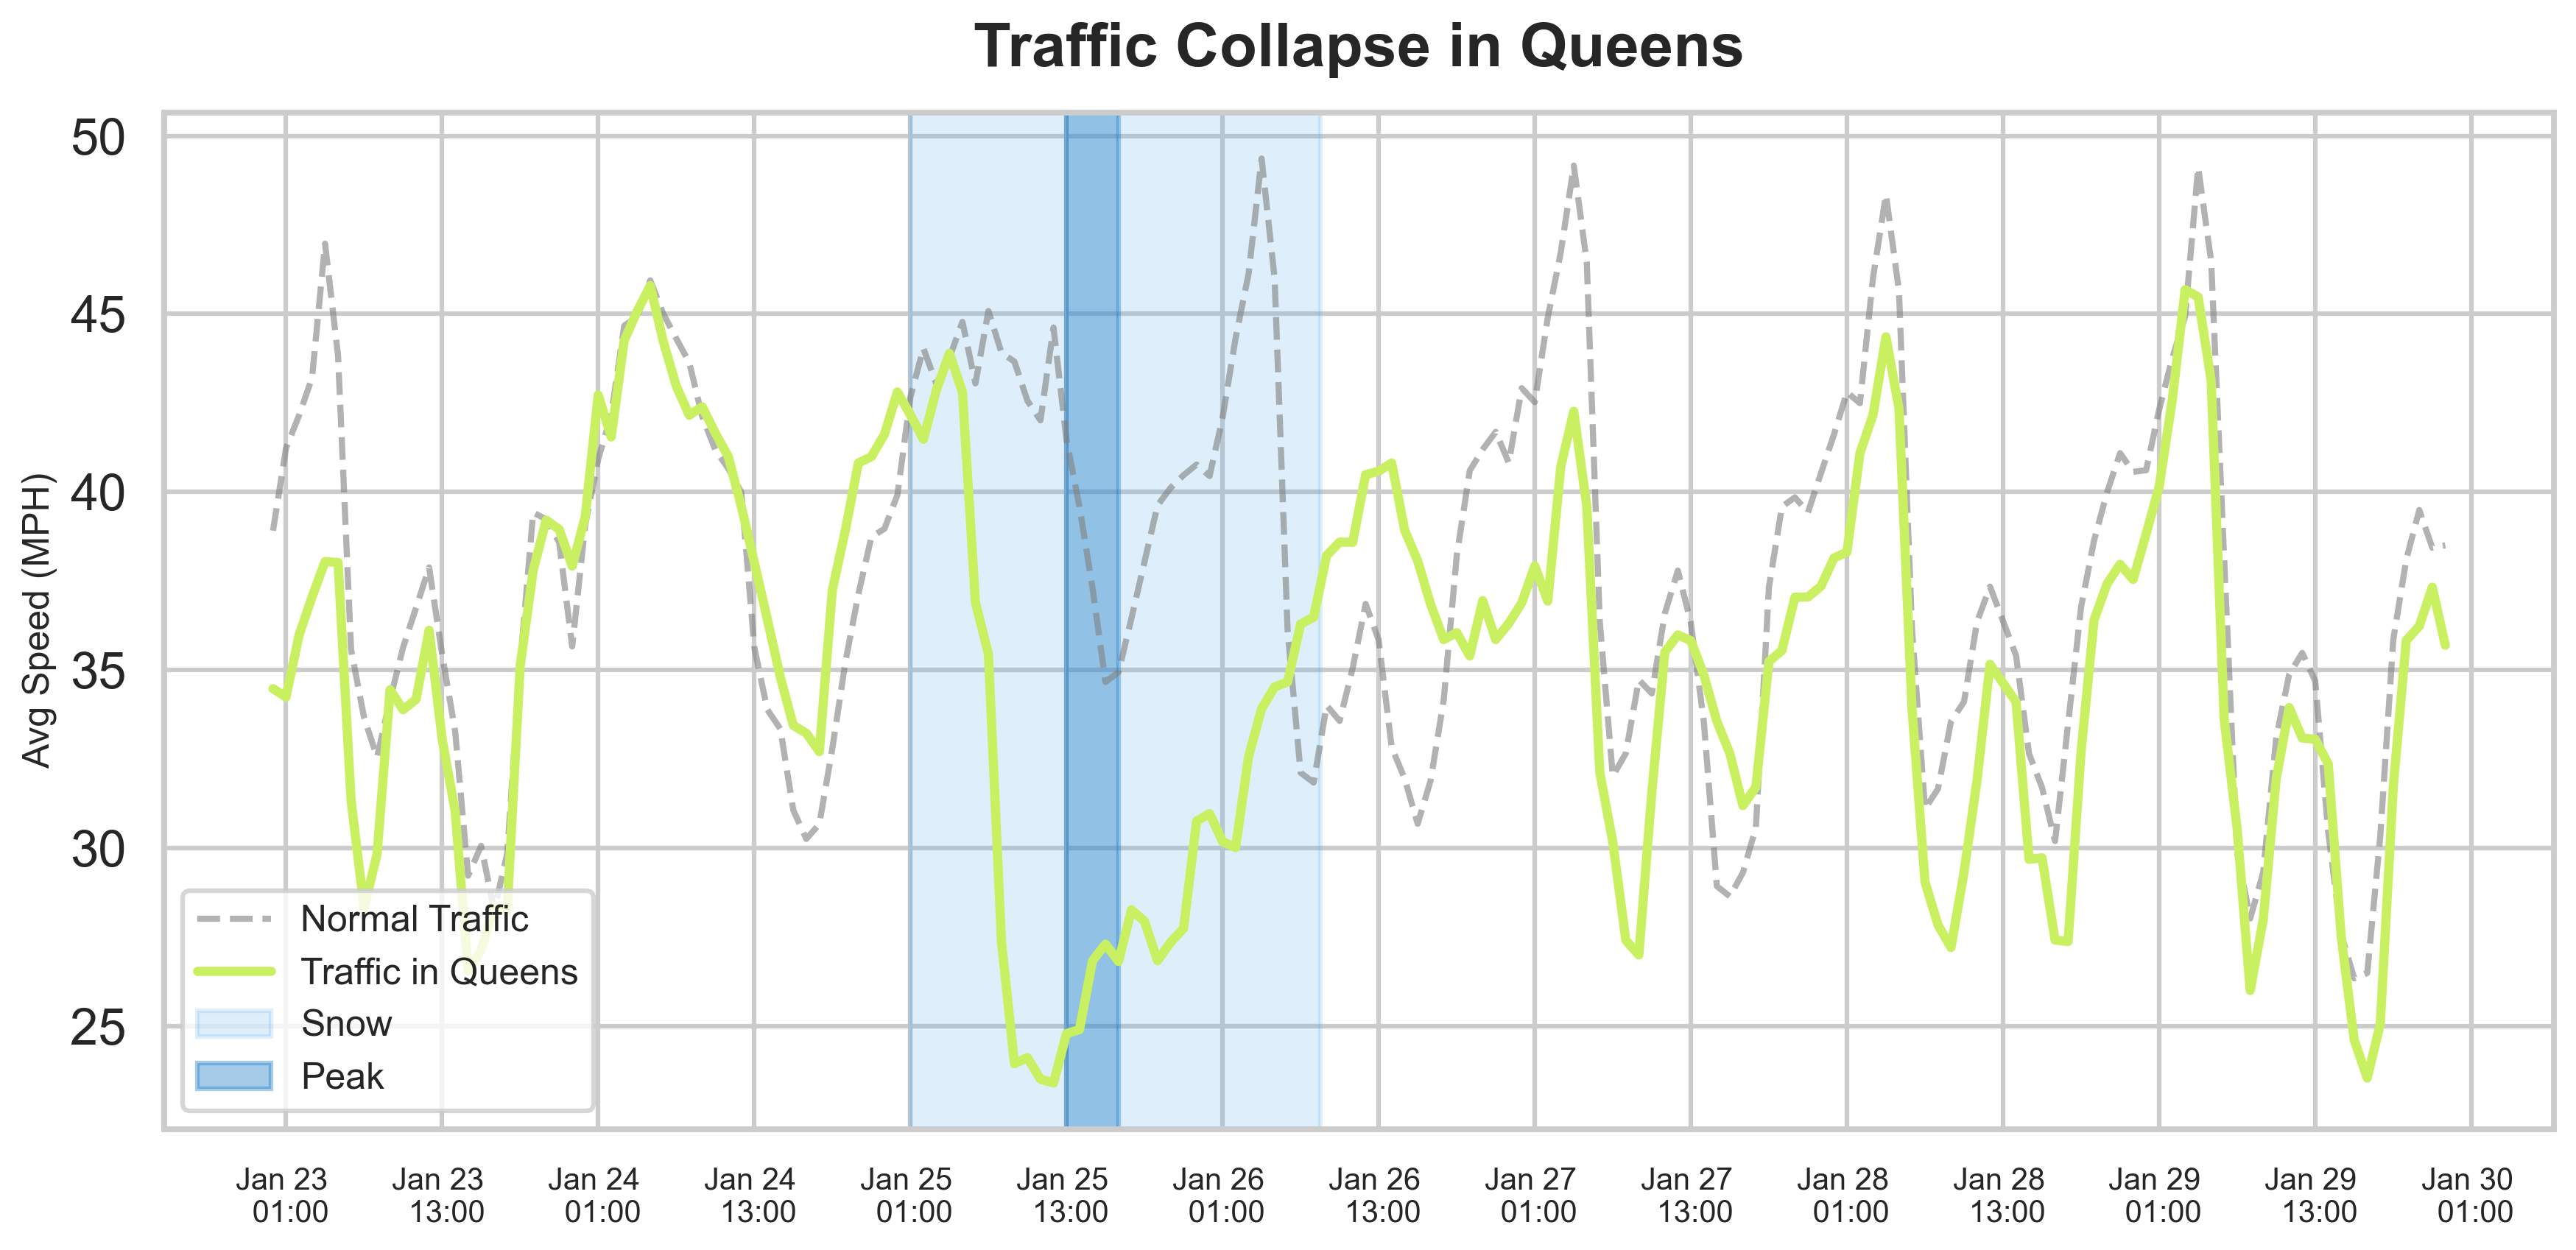

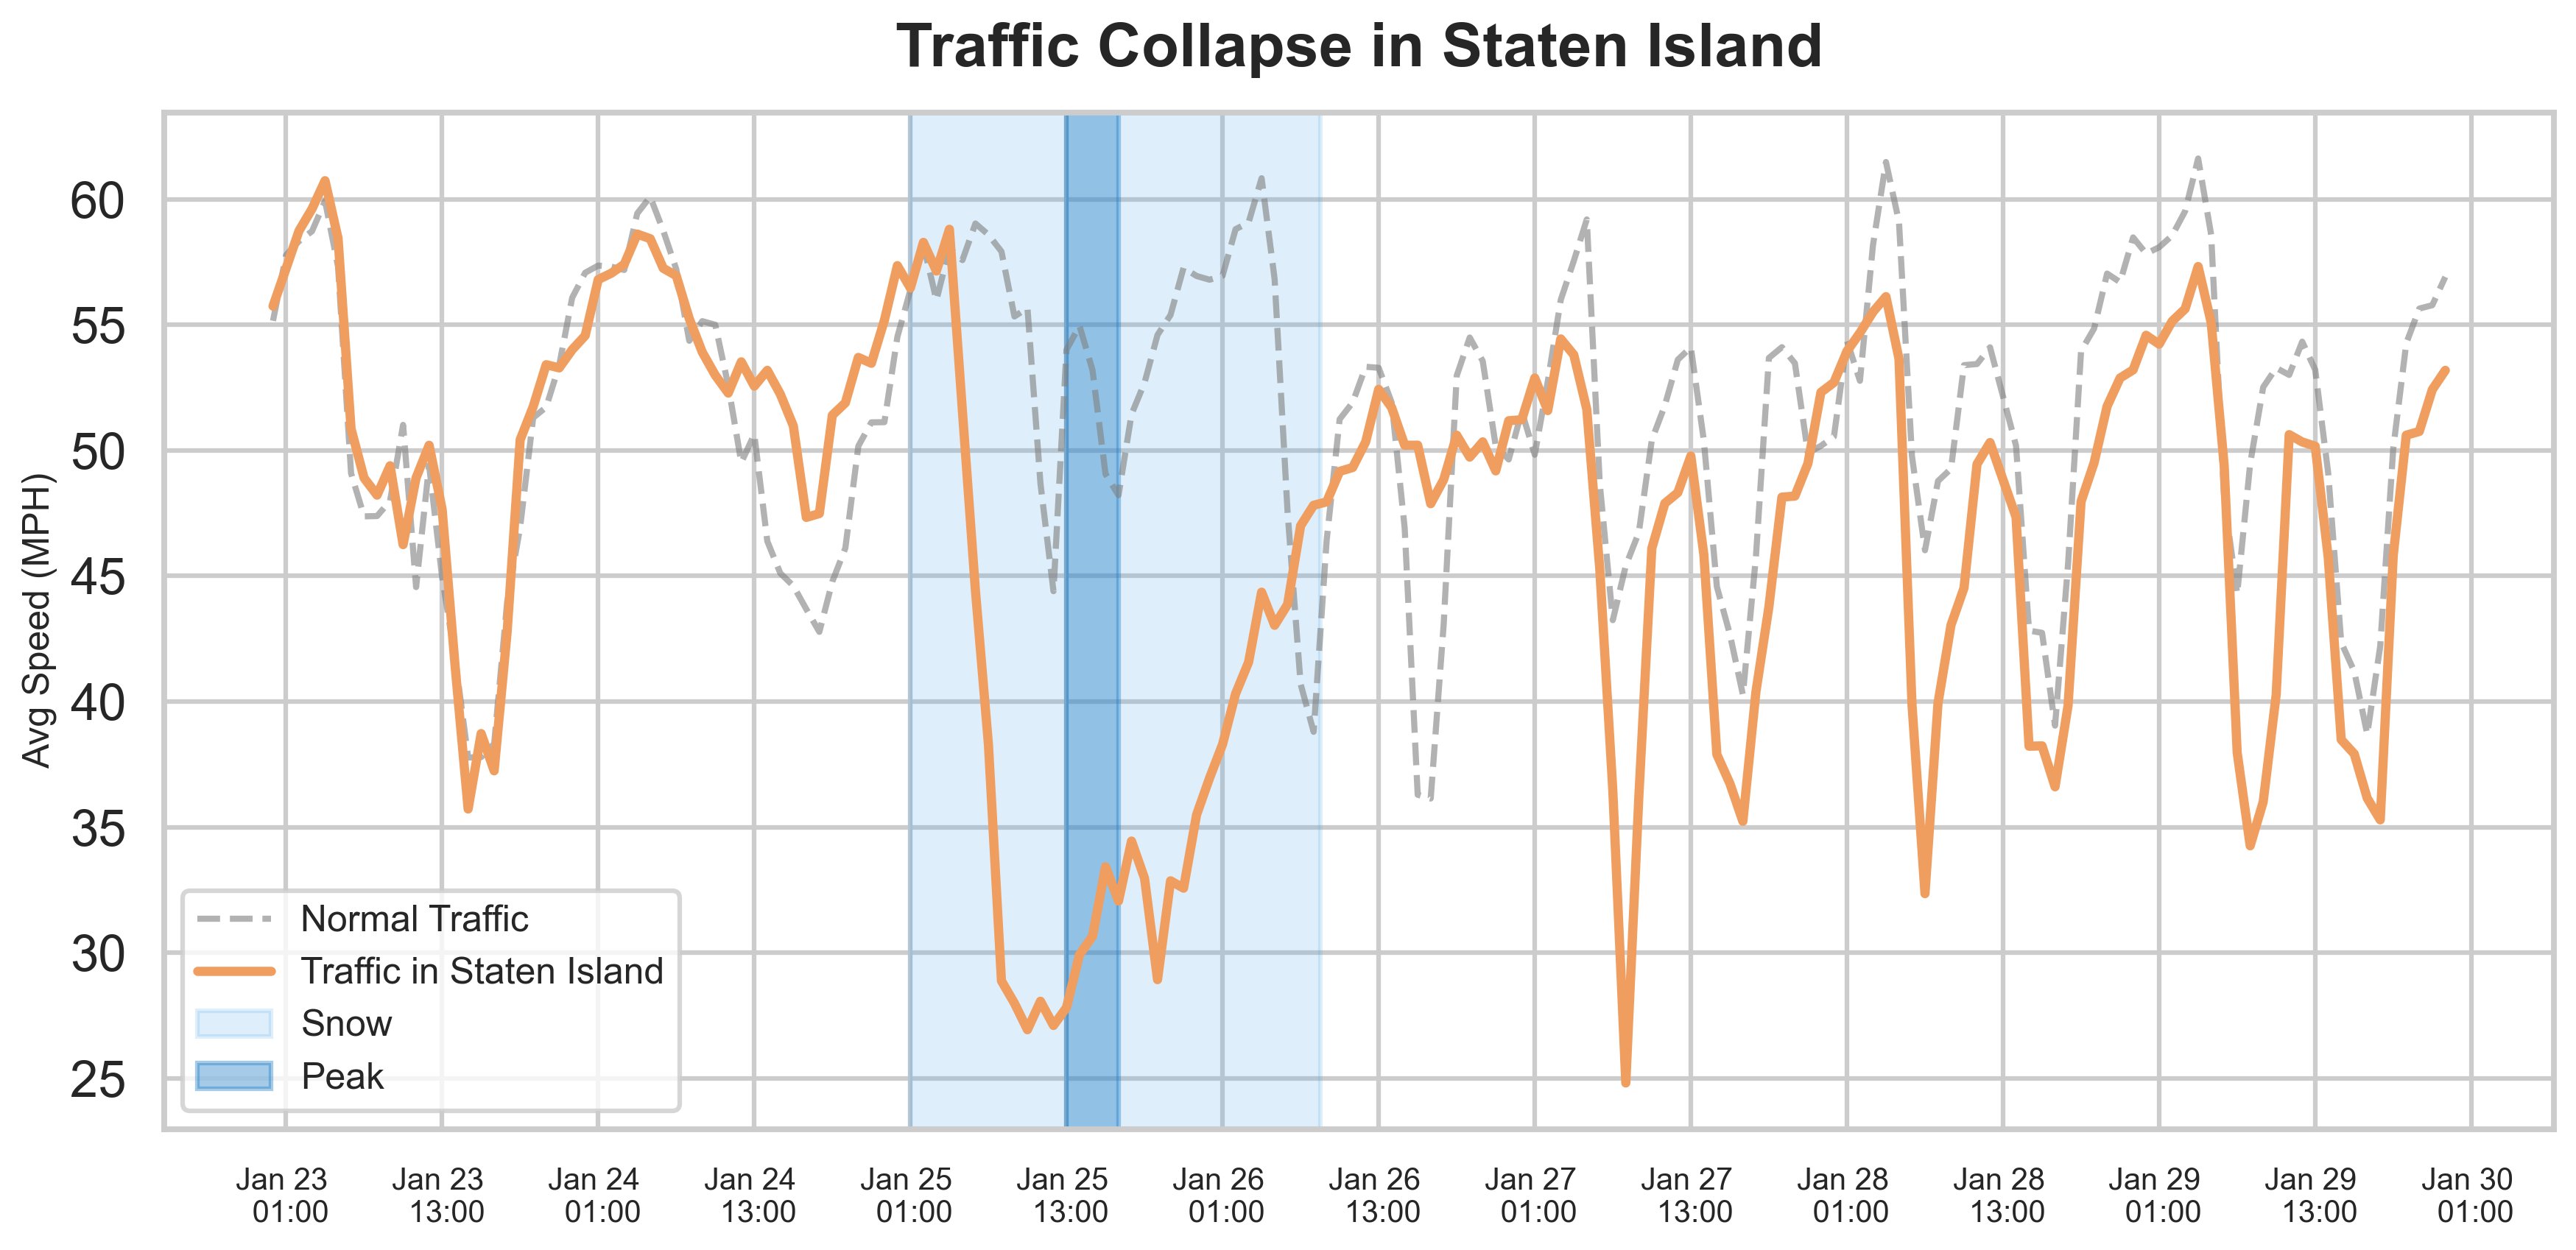

In [8]:
sns.set_theme(style="whitegrid", context="talk") 
plt.rcParams['figure.dpi'] = 300
borough_palette = {
    'Manhattan': '#c560f0',     
    'Brooklyn': '#44939c',
    'Queens': '#c9f060',
    'Staten Island': '#f09d60', 
    'Bronx': '#5fe1ef'
}
average_palette = '#3C5461'
snow_palette = {
    'snow' : '#5cabe7',
    'peak' : '#1e7ec7'
}

snow_start = pd.Timestamp("2026-01-25 01:00:00")
snow_peak_start = pd.Timestamp("2026-01-25 13:00:00")
snow_peak_end = pd.Timestamp("2026-01-25 17:00:00")
snow_end = pd.Timestamp("2026-01-26 08:30:00")


df_storm = pd.read_csv("../data/nyc_traffic_storm.csv")
df_base = pd.read_csv("../data/nyc_traffic_baseline.csv")

def clean_data(df):
    df['data_as_of'] = pd.to_datetime(df['data_as_of'])
    df['speed'] = pd.to_numeric(df['speed'], errors='coerce')
    df = df[df['speed'] > 0]
    df['timestamp'] = df['data_as_of'].dt.floor('h')
    return df

df_storm = clean_data(df_storm)
df_base = clean_data(df_base)

print("Generating Chart 1: The Citywide...")

city_base = df_base.groupby([df_base['data_as_of'].dt.day_name(), df_base['data_as_of'].dt.hour])['speed'].mean()
city_avg = df_storm.groupby('timestamp')['speed'].mean().reset_index()

def get_normal_speed(row):
    day = row['timestamp'].day_name()
    hour = row['timestamp'].hour
    return city_base.get((day, hour), float('nan'))

city_avg['normal_speed'] = city_avg.apply(get_normal_speed, axis=1)

fig, ax = plt.subplots(figsize = (12, 6))

ax.plot(city_avg['timestamp'], city_avg['normal_speed'], 
         color='grey', linestyle='--', linewidth=2, alpha=0.6, label='Normal Traffic')
ax.plot(city_avg['timestamp'], city_avg['speed'], 
         color=average_palette, linewidth=3, label='Traffic in the week of snow storm')

ax.axvspan(snow_start, snow_end, color=snow_palette.get('snow'), alpha=0.2, label='Snow')
ax.axvspan(snow_peak_start, snow_peak_end, color=snow_palette.get('peak'), alpha=0.4, label='Peak')
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[1, 13]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d \n %H:%M'))

plt.title("Citywide Traffic Collapse", fontsize=20, fontweight='bold', pad=15)
plt.ylabel("Avg Speed (MPH)", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('images/Citywide.png')
plt.show()

print("Generating Chart 2: The Borough Divide...")

boroughs = sorted(df_storm['borough'].unique())

for i in boroughs:
    b = df_storm[df_storm['borough']==i]
    b_avg = b.groupby('timestamp')['speed'].mean().reset_index()

    b_base = df_base[df_base['borough']==i].groupby([df_base['data_as_of'].dt.day_name(), df_base['data_as_of'].dt.hour])['speed'].mean()
    
    def get_normal_speed(row):
        day = row['timestamp'].day_name()
        hour = row['timestamp'].hour
        return b_base.get((day, hour), float('nan'))

    b_avg['normal_speed'] = b_avg.apply(get_normal_speed, axis=1)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(b_avg['timestamp'], b_avg['normal_speed'], 
            color='grey', linestyle='--', linewidth=2, alpha=0.6, label='Normal Traffic')
    
    ax.plot(b_avg['timestamp'], b_avg['speed'], 
            color=borough_palette.get(i), linewidth=3, label=f'Traffic in {i}')

    ax.axvspan(snow_start, snow_end, color=snow_palette.get('snow'), alpha=0.2, label='Snow')
    ax.axvspan(snow_peak_start, snow_peak_end, color=snow_palette.get('peak'), alpha=0.4, label='Peak')

    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[1, 13]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d \n %H:%M'))

    plt.title(f"Traffic Collapse in {i}", fontsize=20, fontweight='bold', pad=15)
    plt.ylabel("Avg Speed (MPH)", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.legend(fontsize=12, loc='lower left')
    plt.tight_layout()
    plt.savefig(f'images/Boroughwide:{i}.png')
    plt.show()